In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
model_size = 'small'
model_list = ['lightgbm','xgboost','random_forest']
embedding = 'hyena'
tissue = 'CD4'
data_path = '../../datasets/datasets_embedding/dnabert2/'
image_path = 'images/'
# set seed
seed = 100
import random
random.seed(seed)
np.random.seed(seed)

train_data = pd.read_pickle(data_path + model_size + '_train.dataset')
valid_data = pd.read_pickle(data_path + model_size + '_valid.dataset')
test_data = pd.read_pickle(data_path + model_size + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['dnabert_before'][i].flatten().tolist()
    feature_list += train_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['Beta'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['dnabert_before'][i].flatten().tolist()
    feature_list += test_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['Beta'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

          CpG              SNP      Beta Ref Alt   CHR    CpG_POS    SNP_POS  \
0  cg13250850   1:76251746_T_C  1.731170   T   C  chr1   76250734   76251746   
1  cg22992797  1:213180791_G_A -2.291613   G   A  chr1  213181989  213180791   
2  cg18815120  1:231505587_T_A  1.516844   T   A  chr1  231512676  231505587   
3  cg12835689   1:94063844_C_A -2.829600   C   A  chr1   94057740   94063844   
4  cg18621232   1:31677346_C_T  3.458530   C   T  chr1   31681696   31677346   

                                          seq_before  \
0  ggcctcctaggcatgcagaactgtgagtcaattggacttatttcct...   
1  gagtagctgggactacaggcgcccaccaccacacctagctaatttt...   
2  AGTTAAAGAAAAGAAGGTAAGTGGTCCATCAGATGGGAAACAGACC...   
3  GAGTGAGGCCAGATGGATCCCCTCCTTCCAAACCTACAAAAGCCAG...   
4  CGCCAACCCCAGGAGCCCACACAAGGTGGGGAGTGAGGGACAAGGG...   

                                           seq_after  seq_len  \
0  ggcctcctaggcatgcagaactgtgagtcaattggacttatttcct...    20001   
1  gagtagctgggactacaggcgcccaccaccacacctagctaatttt...

In [4]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'n_estimators': 28}
{'max_depth': 50}


rmse= 2.13753378886604
r2= 0.5603910590392691
pcc= 0.7507189495907093
pcc_p= 4.059024510112358e-73


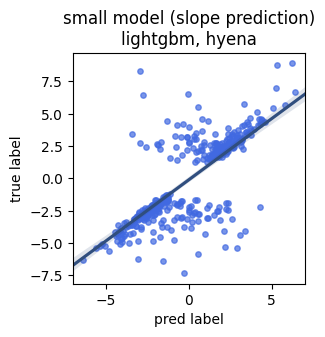

In [5]:
model = model_list[0]

import lightgbm as lgb
clf_lgb = lgb.LGBMRegressor(max_depth=28, num_leaves=50)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#4169E1','alpha':0.7,'s':15}, line_kws={"color": "#304E7E"},truncate=False)
plt.title('small model (slope prediction)\n' + model + ', ' + embedding)

plt.savefig(image_path + 'cm-small-slope-' + model + '-' + embedding + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [6]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 300}
{'max_depth': 9}


rmse= 2.0892569525936606
r2= 0.5800242137487883
pcc= 0.7622279181694763
pcc_p= 1.2868459211481093e-76


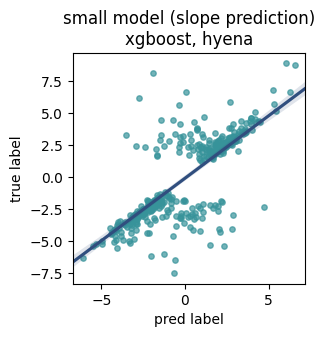

In [7]:
import xgboost as xgb

model = model_list[1]
clf_lgb = lgb.LGBMRegressor(max_depth=9, num_leaves=300)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#37939A','alpha':0.7,'s':15}, line_kws={"color": "#304E7E"},truncate=False)
plt.title('small model (slope prediction)\n' + model + ', ' + embedding)

plt.savefig(image_path + 'cm-small-slope-' + model + '-' + embedding + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 73}
{'max_depth': 10}


rmse= 2.0892569525936606
r2= 0.5800242137487883
pcc= 0.7622279181694763
pcc_p= 1.2868459211481093e-76


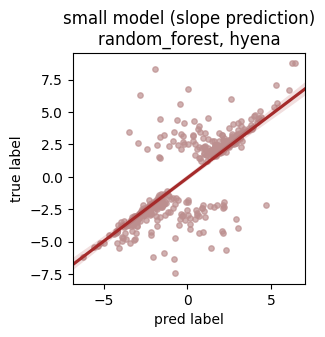

In [9]:
model = model_list[2]

from sklearn.ensemble import RandomForestRegressor
clf_rf = RandomForestRegressor(n_estimators=73, max_depth=10)
clf_rf.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#BC8F8F','alpha':0.7,'s':15}, line_kws={"color": "#A52A2A"},truncate=False)
plt.title('small model (slope prediction)\n' + model + ', ' + embedding)

plt.savefig(image_path + 'cm-small-slope-' + model + '-' + embedding + '.png',dpi=300, bbox_inches = 'tight')
plt.show()